In [34]:
import os
from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
comments_dir = '/projects/bdata/bdatasets/photocritique/comments_jun_2021/'
posts_dir = '/projects/bdata/bdatasets/photocritique/posts_jun_2021/'

In [3]:
comments_dtype = {
    'id'          : 'str',
    'subreddit'   : 'str',
    'link_id'     : 'str',
    'author'      : 'str',
    'created_utc' : 'int',
    'score'       : 'int',
    'body'        : 'str',
}

In [4]:
posts_dtype = {
    'id'          : 'str',
    'subreddit'   : 'str', 
    'author'      : 'str', 
    'created_utc' : 'int', 
    'score'       : 'int', 
    'title'       : 'str', 
    'url'         : 'str',
}

In [5]:
comments = pd.concat(
    [pd.read_json(p, lines=True, dtype=comments_dtype) for p in glob(os.path.join(comments_dir, 'part-*.json'))],
    axis = 'index',
)
print(f'Loaded {len(comments)} comments from {len(glob(os.path.join(comments_dir, "part-*.json"))):,d} files.')

Loaded 8482 comments from 1,960 files.


In [6]:
posts = pd.concat(
    [pd.read_json(p, lines=True, dtype=posts_dtype) for p in glob(os.path.join(posts_dir, 'part-*.json'))],
    axis = 'index',
)
print(f'Loaded {len(posts)} posts from {len(glob(os.path.join(posts_dir, "part-*.json"))):,d} files.')

Loaded 1718 posts from 810 files.


In [7]:
# need new index since the previous one is a mismatch of all the sub dfs we concat'd
comments.index = pd.RangeIndex(stop=len(comments))
posts.index    = pd.RangeIndex(stop=len(posts))

In [8]:
comments.loc[:,'created_utc'] = pd.to_datetime(comments.created_utc, unit='s')
posts.loc[   :,'created_utc'] = pd.to_datetime(   posts.created_utc, unit='s')

In [9]:
# for now, exclude automod comments
comments = comments.loc[comments.author!='AutoModerator',:]

# number of comments per post

start by counting then join

In [10]:
num_comments = comments.groupby(by='link_id').agg({'subreddit':'count'}).subreddit.rename('num_comments')
num_comments.index = num_comments.index.str.slice(start=3)

In [11]:
posts = posts.join(num_comments, on='id', how='left')
posts = posts.fillna(value={'num_comments':0})

In [12]:
posts.num_comments.describe()

count    1718.000000
mean        3.870780
std         9.000463
min         0.000000
25%         0.000000
50%         1.000000
75%         4.000000
max       142.000000
Name: num_comments, dtype: float64

In [13]:
comments.loc[comments.author!='AutoModerator',:]

,id,subreddit,link_id,author,created_utc,score,body
0,h0kp9tg,photocritique,t3_nrztco,ITGuyToTheRescue,2021-06-04 15:03:26,1,That’s a very interesting take. Thanks for the...
1,h0kpqny,photocritique,t3_ns2hid,Shoogled,2021-06-04 15:06:56,33,I do find it disappointing when these details ...
2,h0kqd6s,photocritique,t3_ns2hid,[deleted],2021-06-04 15:11:31,1,[removed]
3,h0kqgca,photocritique,t3_nrxggh,IAmScience,2021-06-04 15:12:10,1,&gt; im still struggling with the composition ...
5,h0kqrsg,photocritique,t3_ns2hid,ITdoug,2021-06-04 15:14:31,4,"Nice crop. I do prefer the original as, in my ..."
...,...,...,...,...,...,...,...
8475,h0x3ugw,photocritique,t3_nufgdf,jakeisnt,2021-06-07 15:35:08,1,I took this photo driving around in Boston at ...
8477,h0x4g92,photocritique,t3_nu51z1,rriskm,2021-06-07 15:39:25,1,Of couse! I just havent decided on a good one ...
8478,h0x4xbt,photocritique,t3_nufix7,courtney7070,2021-06-07 15:42:53,1,"I really want her features to show through, ra..."
8480,h11zhru,photocritique,t3_nuae6r,SarcasticNarcissist1,2021-06-08 17:54:51,2,I didn't think much about the green at first b...


# comment length

In [16]:
comments.body.str.len().describe()

count    6757.000000
mean      254.505994
std       307.217750
min         1.000000
25%        62.000000
50%       170.000000
75%       335.000000
max      5394.000000
Name: body, dtype: float64

# age of comments

In [23]:
post_times = posts.set_index('id').created_utc
post_times.index = 't3_' + post_times.index

In [28]:
comments = comments.join(post_times, on='link_id', rsuffix='_post', how='left')

In [31]:
comments.loc[:,'post_age_at_time_of_comment'] = comments.created_utc - comments.created_utc_post

In [40]:
comments.post_age_at_time_of_comment

0      0 days 06:53:47
1      0 days 04:01:25
2      0 days 04:06:00
3      0 days 09:45:11
5      0 days 04:09:00
             ...      
8475   0 days 00:00:06
8477   0 days 09:58:16
8478   0 days 00:04:49
8480   1 days 06:09:22
8481   0 days 00:06:14
Name: post_age_at_time_of_comment, Length: 6757, dtype: timedelta64[ns]

In [64]:
total_hours = comments.post_age_at_time_of_comment.dt.total_seconds() / 3600

xs = np.linspace(0, 80, num=1000)
ys = []

for x in xs:
    ys.append( ( total_hours <= x ).sum() / len(total_hours) )

In [65]:
annot_xs = [3, 6, 12, 24, 48, 72]
annot_ys = []

for x in annot_xs:
    annot_ys.append( ( total_hours <= x ).sum() / len(total_hours) )

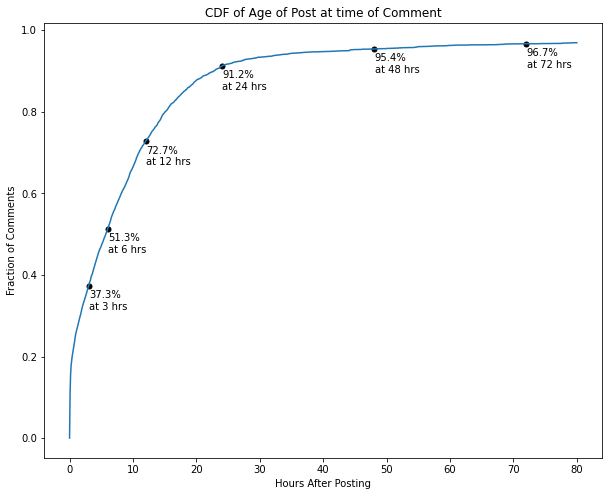

In [66]:
plt.figure(figsize=(10,8))

plt.plot(xs, ys)

for x,y in zip(annot_xs, annot_ys):
    plt.scatter([x],[y], color='black', marker='.', s=100)
    plt.text(x+.1, y-.01, s=f'{100*y:.1f}%\nat {x} hrs', ha='left', va='top')

plt.title('CDF of Age of Post at time of Comment')
plt.xlabel('Hours After Posting')
plt.ylabel('Fraction of Comments')

plt.show()